# DeScoD-ECG (Li et al., 2023)

##### Modules

In [2]:
import sys
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from torch.utils.data import DataLoader
from IPython.display import Image
from scipy.fft import fft, fftshift
from scipy.io import loadmat
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset

In [15]:
folder_path = "C:/Users/matth/Documents/Columbia/SAIL/ddpm-mrs/"
data_path = "C:/Users/matth/Documents/Columbia/SAIL/ddpm-mrs/data/"

model_name = "test_0"
model_path = "C:/Users/matth/Documents/Columbia/SAIL/Score-based-ECG-Denoising/" + model_name + "/final.pth"

sys.path.append(folder_path)
os.chdir(folder_path)

from main_model import DDPM
from denoising_model_small import ConditionalModel

##### Model

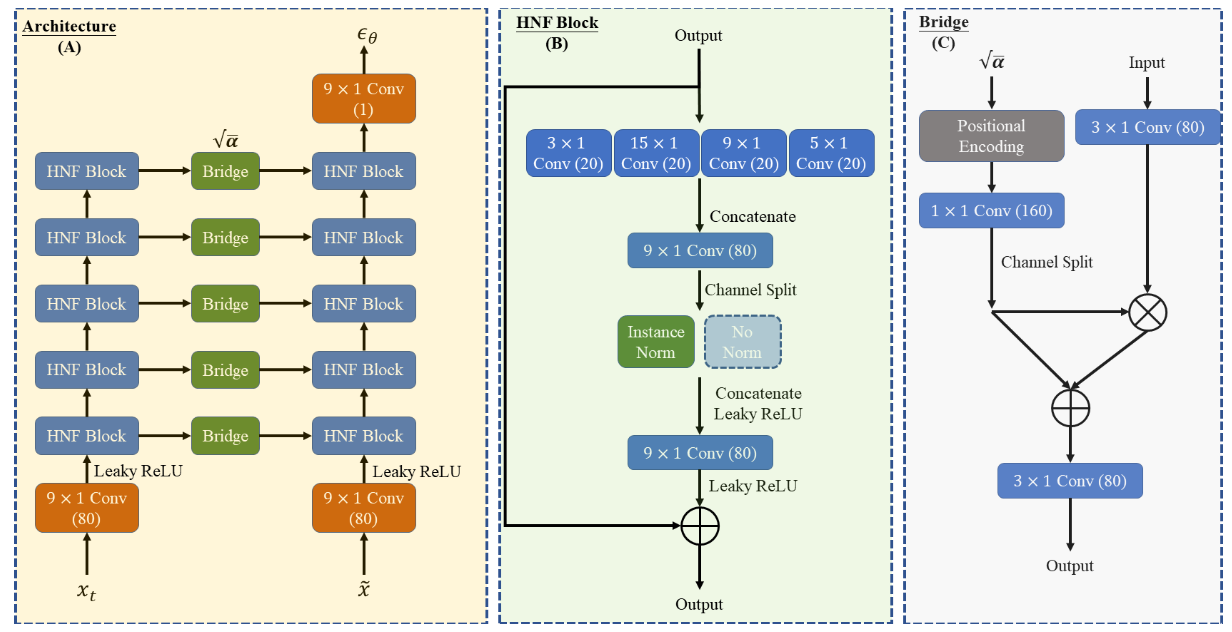

In [16]:
display(Image(filename='img.png'))

##### Data

In [17]:
train_set = torch.load(os.path.join(data_path, "train_set.pt"))
val_set = torch.load(os.path.join(data_path, "val_set.pt"))
test_set = torch.load(os.path.join(data_path, "test_set.pt"))

##### Training

##### Inference

In [18]:
device = "cuda:0"
path = "./config/base.yaml"
with open(path, "r") as f:
    config = yaml.safe_load(f)

In [19]:
print("Initializing base model.. ")
base_model = ConditionalModel(config['train']['feats']).to(device)
print("Initializing DDPM.. ")
model = DDPM(base_model, config, device)
print("Done.")

Initializing base model.. 
Initializing DDPM.. 
Done.


In [20]:
model.load_state_dict(torch.load(model_path))
model.eval()

DDPM(
  (model): ConditionalModel(
    (stream_x): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 80, kernel_size=(9,), stride=(1,), padding=(4,), padding_mode=reflect)
        (1): LeakyReLU(negative_slope=0.2)
      )
      (1): HNFBlock(
        (filters): ModuleList(
          (0): Conv1d(80, 20, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=reflect)
          (1): Conv1d(80, 20, kernel_size=(5,), stride=(1,), padding=(2,), padding_mode=reflect)
          (2): Conv1d(80, 20, kernel_size=(9,), stride=(1,), padding=(4,), padding_mode=reflect)
          (3): Conv1d(80, 20, kernel_size=(15,), stride=(1,), padding=(7,), padding_mode=reflect)
        )
        (conv_1): Conv1d(80, 80, kernel_size=(9,), stride=(1,), padding=(4,), padding_mode=reflect)
        (norm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv_2): Conv1d(80, 80, kernel_size=(9,), stride=(1,), padding=(4,), padding_mode=reflect)
      )
      (2)

##### Performance on test set

In [21]:
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [22]:
test_features, test_labels = next(iter(test_dataloader))
X_test = torch.FloatTensor(test_features[:,0:1]).to(device) #.cpu().numpy()
y_test = torch.FloatTensor(test_labels[:,0:1]).to(device) #.cpu().numpy()
y_test_pred = model.denoising(X_test[:,0:1])#.permute(0,2,1))

In [23]:
X_test.shape

torch.Size([64, 1, 2048])

In [24]:
print("X_test shape: ", X_test.size())
print("y_test shape: ", y_test.size())
print("y_test_pred shape: ", y_test_pred.size())

X_test shape:  torch.Size([64, 1, 2048])
y_test shape:  torch.Size([64, 1, 2048])
y_test_pred shape:  torch.Size([64, 1, 2048])


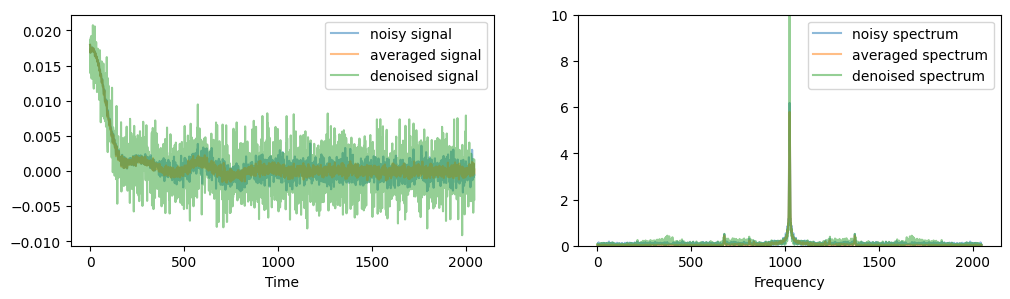

In [25]:
X_test_ar = X_test.cpu().numpy()
y_test_ar = y_test.cpu().numpy()
y_test_pred_ar = y_test_pred.cpu().numpy()

X_test_fft = fftshift(fft(X_test_ar))
y_test_fft = fftshift(fft(y_test_ar))
y_test_pred_fft = fftshift(fft(y_test_pred_ar))

fig, ax = plt.subplots(1, 2, figsize = (12, 3) )
sample = 3

# estimating bias
X = np.vstack((np.ones_like(y_test_ar[sample, 0, :]), y_test_ar[sample, 0, :]))
theta = np.linalg.pinv(X.T) @ y_test_pred_ar[sample, 0, :]

ax[0].plot( X_test_ar[sample, 0], label = "noisy signal", alpha = 0.5)
ax[0].plot( y_test_ar[sample, 0], label = "averaged signal" , alpha = 0.5)
ax[0].plot( y_test_pred_ar[sample, 0] - theta[0], label = "denoised signal", alpha = 0.5)
ax[0].set_xlabel("Time")
ax[0].legend()

ax[1].plot( np.abs(X_test_fft[sample, 0]), label = "noisy spectrum", alpha = 0.5)
ax[1].plot( np.abs(y_test_fft[sample, 0]), label = "averaged spectrum", alpha = 0.5)
ax[1].plot( np.abs(y_test_pred_fft[sample, 0]), label = "denoised spectrum", alpha = 0.5)
ax[1].set_xlabel("Frequency")
ax[1].set_ylim([0, 10])
ax[1].legend()

##### Performance on training set

In [26]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
X_train = torch.FloatTensor(train_features[:,0:1]).to(device) #.cpu().numpy()
y_train = torch.FloatTensor(train_labels[:,0:1]).to(device) #.cpu().numpy()
y_train_pred = model.denoising(X_train[:,0:1])#[..., 0:1].permute(0,2,1))

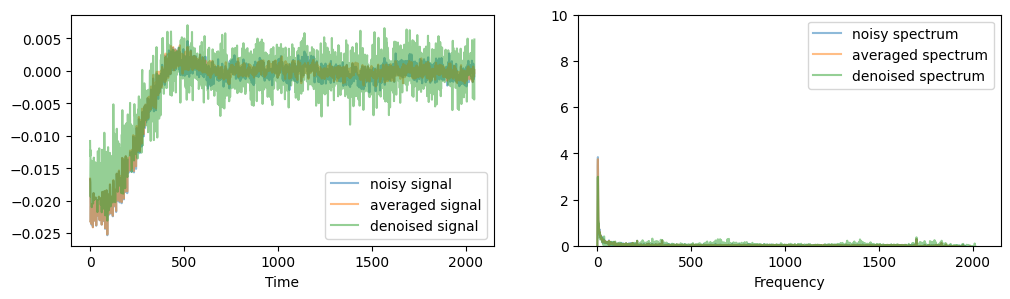

In [28]:
X_train_ar = X_train.cpu().numpy()
y_train_ar = y_train.cpu().numpy()
y_train_pred_ar = y_train_pred.cpu().numpy()

X_train_fft = fft(X_train_ar)
y_train_fft = fft(y_train_ar)
y_train_pred_fft = fft(y_train_pred_ar)

fig, ax = plt.subplots(1, 2, figsize = (12, 3) )
sample = 8

# estimating bias
X = np.vstack((np.ones_like(y_train_ar[sample, 0, :]), y_train_ar[sample, 0, :]))
theta = np.linalg.pinv(X.T) @ y_train_pred_ar[sample, 0, :]

ax[0].plot( X_train_ar[sample,0], label = "noisy signal", alpha = 0.5)
ax[0].plot( y_train_ar[sample,0], label = "averaged signal", alpha = 0.5)
ax[0].plot( y_train_pred_ar[sample, 0] - theta[0], label = "denoised signal", alpha = 0.5)
ax[0].set_xlabel("Time")
ax[0].legend()

ax[1].plot( np.imag(X_train_fft[sample, 0]), label = "noisy spectrum", alpha = 0.5)
ax[1].plot( np.imag(y_train_fft[sample, 0]), label = "averaged spectrum", alpha = 0.5)
ax[1].plot( np.imag(y_train_pred_fft[sample, 0]), label = "denoised spectrum", alpha = 0.5)
ax[1].set_ylim([0, 10])
ax[1].set_xlabel("Frequency")
ax[1].legend()